In [1]:
import os
import time
import math
import random
import subprocess

from tqdm import tqdm
from glob import glob
from pathlib import Path
from tabulate import tabulate
from shutil import copy, copytree
from typing import Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


import tensorflow as tf
from keras import layers
import keras.backend as K
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing import image
from keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall, AUC

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def download_and_extract(download_url, download_path, output_dir):
    try:
        check_dependencies()

        # Download the file without progress display
        subprocess.run(["wget", "-q", download_url, "-O", download_path], check=True)

        # Check if the download was successful before proceeding
        if os.path.exists(download_path):
            # Create the output directory
            os.makedirs(output_dir, exist_ok=True)

            # Extract the contents
            extract_command = ["tar", "-xf", download_path, "-C", output_dir]
            subprocess.run(extract_command, check=True)

            # Remove the tar file after extraction
            os.remove(download_path)
            print("Download and extraction completed successfully.")
        else:
            print("Error: Failed to download the dataset.")
    except subprocess.CalledProcessError as e:
        print(f"Error: {str(e)}")
        
def check_dependencies():
    try:
        subprocess.run(["wget", "--version"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
        subprocess.run(["tar", "--version"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error: Dependency check failed. {e}")
        raise

In [3]:
# Variables
download_url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar"
download_path = "/kaggle/working/256_ObjectCategories.tar"
# download_path = "/content/256_ObjectCategories.tar" # colab
output_dir = "/kaggle/working/data"
# output_dir = "/content/data" # colab

# Function call
download_and_extract(download_url, download_path, output_dir)

Download and extraction completed successfully.


In [4]:
data_path = Path(r"/kaggle/working/data/256_ObjectCategories") # for kaggle
# data_path = Path(r"/content/data/256_ObjectCategories") # for colab


In [5]:
def count_images_per_class(path):
    """
    Prints the number of images in each class in the dataset.

    Parameters:
    -----------
    path: str
        A string representing the path to the data.

    Returns:
    --------
    None. Prints the number of images in each class to console.
    """

    # Printing the header for the output.
    print(f'{"Classes":>28} | {"Images":^6}')
    print("="*40)

    # Looping through each folder in the data path.
    for folder in os.listdir(path):

        # Counting the number of files in the current folder.
        sample_size = len(os.listdir(path / folder))

        # Printing the folder name and the number of files in it.
        print(f"{folder.strip():<29s}|{sample_size}")

# Call the function with the data path as an argument
count_images_per_class(data_path)

                     Classes | Images
151.ostrich                  |109
163.playing-card             |90
143.minaret                  |130
094.guitar-pick              |104
049.cormorant                |106
255.tennis-shoes             |103
013.birdbath                 |98
175.roulette-wheel           |83
204.sunflower-101            |80
116.iguana                   |107
196.spaghetti                |104
162.picnic-table             |91
242.watermelon               |93
176.saddle                   |110
052.crab-101                 |85
102.helicopter-101           |88
128.lathe                    |105
110.hourglass                |85
070.fire-extinguisher        |84
050.covered-wagon            |97
238.video-projector          |97
248.yarmulke                 |84
215.telephone-box            |84
193.soccer-ball              |174
099.harpsichord              |80
187.skyscraper               |95
247.xylophone                |92
105.horse                    |270
082.galaxy                 

In [6]:
def prepare_data(path: str, b_size: int) -> tuple:
    """Prepares training, validation, and test dataframes along with their respective steps.

    Args:
        path (str): The path to the directory containing the data.
        b_size (int): The batch size for training.

    Returns:
        tuple: A tuple containing the training dataframe, validation dataframe, test dataframe,
        training steps, validation steps, and test steps.
    """
    file_paths = []
    labels = []

    for claass in sorted(os.listdir(path)):
        c_pth = os.path.join(path, claass)

        for file in os.listdir(c_pth):
            file_path = os.path.join(c_pth, file)
            file_paths.append(file_path)
            
            # Extract class name by removing numeric prefix
            class_name = claass.split('.', 1)[1]  # Remove numeric prefix
            labels.append(class_name)

    print(f"Files: {len(file_paths)}\nLabels: {len(labels)}\n")

    files_series = pd.Series(file_paths, name="file_paths")
    labels_series = pd.Series(labels, name="labels")

    d = pd.concat([files_series, labels_series], axis=1)

    train_d, test_data_d = train_test_split(d, test_size=.1, stratify=d.labels, random_state=81)
    train_d, valid_d = train_test_split(train_d, test_size=.2, stratify=train_d.labels, random_state=81)

    print(f"Training Data: {train_d.shape[0]} samples\nTesting Data: {test_data_d.shape[0]} samples\nValidation Data: {valid_d.shape[0]} samples\n")

    return d, labels, train_d, valid_d, test_data_d

BATCH_SIZE = 6
df, labels, train_df, valid_df, test_df = prepare_data(data_path, BATCH_SIZE)

Files: 30609
Labels: 30609

Training Data: 22038 samples
Testing Data: 3061 samples
Validation Data: 5510 samples



In [7]:
def create_counts_table(d, test_d, train_d, valid_d):
    # Creating lists of the "labels" column from the data frames.
    df_labels = d["labels"]
    test_labels = test_d["labels"]
    train_labels = train_d["labels"]
    valid_labels = valid_d["labels"]

    # Printing the header for the output.
    print(f'{"Classes":>25} | {"Test":^4} | {"Train":^5} | {"Valid":^5}')
    print("="*50)

    # Looping through each unique class in the "labels" column.
    for c in df_labels.unique():

        # Counting the number of times the current class appears in each data frame.
        test_count = list(test_labels).count(c)
        train_count = list(train_labels).count(c)
        valid_count = list(valid_labels).count(c)

        # Printing the class name and the counts for each data frame.
        print(f"{c:>25} | {test_count:^4} | {train_count:^5} | {valid_count}")

create_counts_table(df, test_df, train_df, valid_df)

                  Classes | Test | Train | Valid
                     ak47 |  10  |  70   | 18
            american-flag |  10  |  70   | 17
                 backpack |  15  |  109  | 27
             baseball-bat |  13  |  91   | 23
           baseball-glove |  15  |  106  | 27
          basketball-hoop |  9   |  65   | 16
                      bat |  11  |  76   | 19
                  bathtub |  23  |  167  | 42
                     bear |  10  |  74   | 18
                 beer-mug |  9   |  68   | 17
                billiards |  28  |  200  | 50
               binoculars |  22  |  155  | 39
                 birdbath |  10  |  70   | 18
                    blimp |  9   |  62   | 15
               bonsai-101 |  12  |  88   | 22
                 boom-box |  9   |  66   | 16
             bowling-ball |  10  |  75   | 19
              bowling-pin |  10  |  73   | 18
             boxing-glove |  12  |  90   | 22
                brain-101 |  8   |  60   | 15
               breadmaker |  14

In [8]:
def load_data(df, b_size=BATCH_SIZE, shuffle=True, random_state=81, workers=1):
    generator = image.ImageDataGenerator(
        rescale=1 / 255.,
        # Add more augmentation parameters if needed
    )

    data = generator.flow_from_dataframe(
        df,
        x_col="file_paths",
        y_col="labels",
        target_size=(224, 224),
        class_mode="categorical",
        shuffle=shuffle,
        batch_size=b_size,
        seed=random_state,
        workers=workers
    )

    # Print a warning for invalid filenames
    invalid_filenames = df.loc[~df['file_paths'].isin(data.filenames), 'file_paths']
    if not invalid_filenames.empty:
        print("Warning: Invalid filenames found and will be ignored:", invalid_filenames.tolist())

    return data

# Load the training, validation, and test data with consistent random_state
train_data = load_data(train_df)
valid_data = load_data(valid_df, shuffle=False)
test_data = load_data(test_df, shuffle=False)

Found 22036 validated image filenames belonging to 257 classes.
Found 5510 validated image filenames belonging to 257 classes.
Found 3061 validated image filenames belonging to 257 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="file_paths". These filename(s) will be ignored.
  warnings.warn(


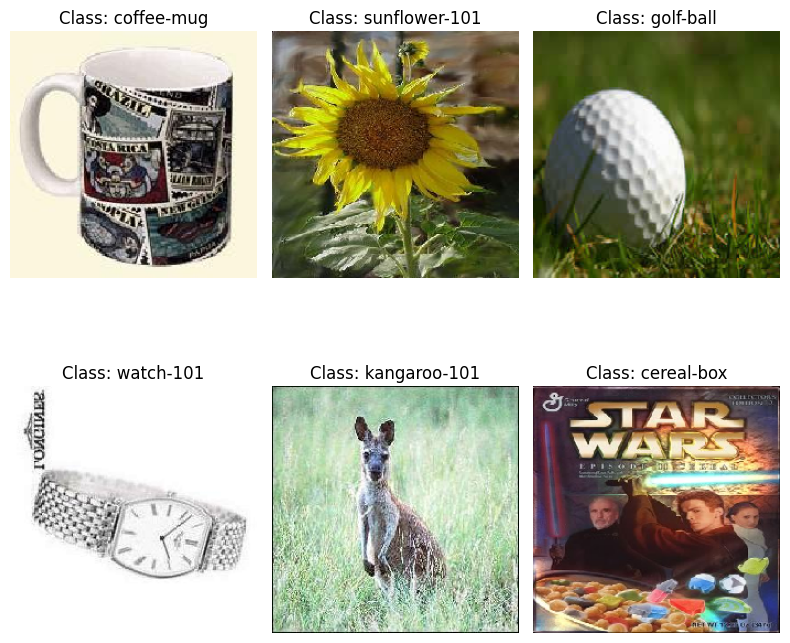

In [9]:
def display_random_images(data_generator, class_names, num_images=16):
    # Get a new batch of images and labels from the generator
    batch = next(data_generator)
    images, labels = batch

    # Ensure that the number of requested images is not greater than the batch size
    num_images = min(num_images, len(images))

    # Get random indices to select images from the batch
    random_indices = random.sample(range(len(images)), num_images)

    # Convert dict_keys to a list for subscripting
    class_names = list(class_names)

    # Display the random images with class names in a square plot
    plt.figure(figsize=(8, 8))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(image.array_to_img(images[idx]))
        plt.title(f"Class: {class_names[labels[idx].argmax()]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get class names from the training data
class_names = train_data.class_indices.keys()

display_random_images(train_data, class_names)

In [10]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """Calculates the F1 score."""
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """Calculates the specificity."""
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """Calculates the sensitivity."""
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).
        
        This approach allows for a nuanced assessment of the model's ability to distinguish
        between different classes, making it particularly valuable in scenarios where classes
        may have varying levels of significance.
        
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """Calculates the number of true positives."""
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """Calculates the number of false positives."""
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """Calculates the number of false negatives."""
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """Calculates the number of true negatives."""
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """Calculates the components of the confusion matrix."""
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

custom_metrics = create_metrics()

# precision_metric, recall_metric, f1_score_metric, specificity_metric, sensitivity_metric, mcc_metric, auc_metric = custom_metrics

In [12]:
base_model = ResNet50V2(weights='imagenet')
base_model.trainable = True 

# Calculate the number of layers in the base model
num_layers = len(base_model.layers)

# Freeze the first 50% of layers
for layer in base_model.layers[:num_layers//2]:
    layer.trainable = False

base_model.summary()

102869336/102869336 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                      

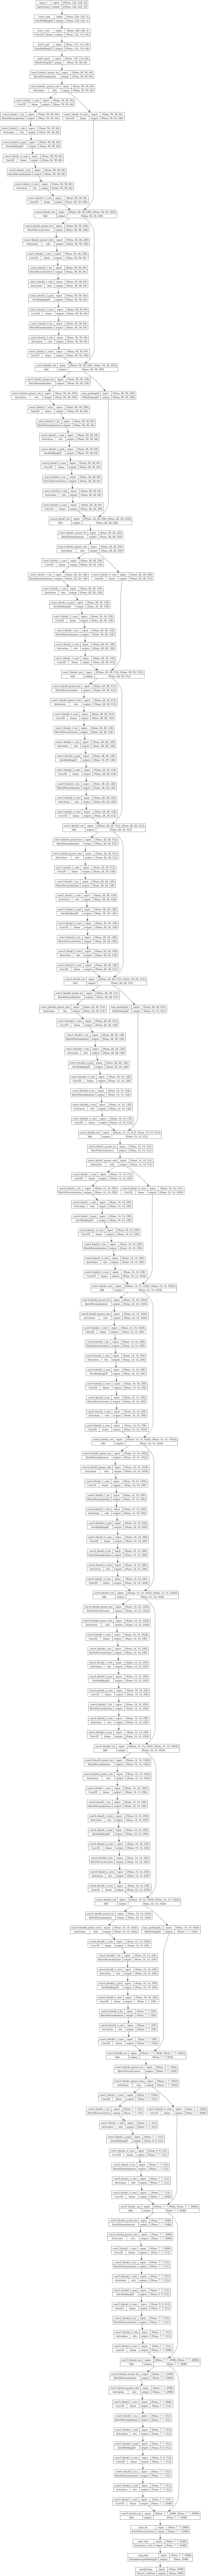

In [13]:
plot_model(base_model, to_file='original_model.png', show_shapes=True, show_layer_activations=True)

In [14]:
layer_name_1 = 'conv5_block1_out'
selected_layer_1_output = base_model.get_layer(layer_name_1).output

# novel block (vertical concat)
x = MaxMinPooling2D(pool_size=(5, 5), name="NMaxMinPool")(selected_layer_1_output)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name="NConv1")(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name="NConv2")(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name="NConv3")(x)
x = GlobalAveragePooling2D(name="NGAP")(x)

layer_name_2 = 'avg_pool'
selected_layer_2_output = base_model.get_layer(layer_name_2).output

concatenated_output = tf.keras.layers.concatenate([selected_layer_2_output, x], axis=-1)

dense_output = Dense(257, activation='softmax')(concatenated_output)

# Create a new model
new_model = Model(inputs=base_model.input, outputs=dense_output)

new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

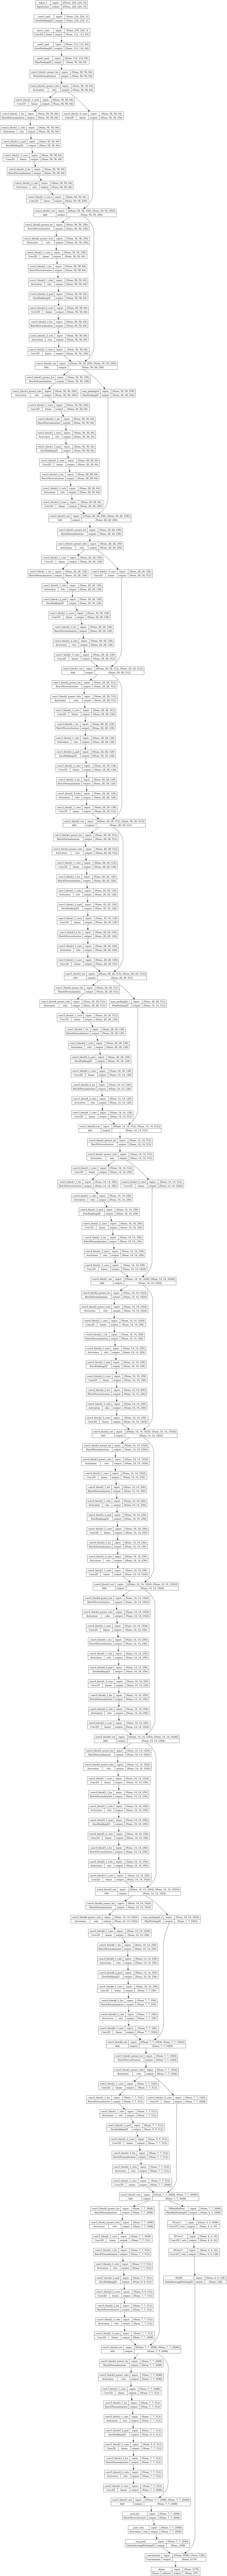

In [15]:
plot_model(new_model, to_file='modified_model.png', show_shapes=True, show_layer_activations=True)

In [16]:
class TimeCallback(tf.keras.callbacks.Callback):
    """Custom callback to record epoch times and total training time."""

    def on_train_begin(self, logs=None):
        """Initialize training start time and epoch times."""
        self.train_start_time = time.perf_counter()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        """Record start time of each epoch."""
        self.epoch_start_time = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        """Calculate and store epoch time."""
        epoch_time = time.perf_counter() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        """Calculate total training time."""
        self.total_train_time = time.perf_counter() - self.train_start_time

time_callback = TimeCallback()

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [18]:
new_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()]
)

history = new_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[time_callback, early_stopping]
)

Epoch 1/50
3673/3673 [==============================] - 188s 45ms/step - loss: 2.3249 - accuracy: 0.5049 - precision_1: 0.8762 - recall_1: 0.3122 - f1_score: 0.4200 - specificity: 0.9998 - sensitivity: 0.3122 - mcc: 0.4679 - auc_1: 0.9349 - val_loss: 1.4807 - val_accuracy: 0.6789 - val_precision_1: 0.7792 - val_recall_1: 0.6218 - val_f1_score: 0.6850 - val_specificity: 0.9993 - val_sensitivity: 0.6221 - val_mcc: 0.6920 - val_auc_1: 0.9542
Epoch 2/50
3673/3673 [==============================] - 163s 45ms/step - loss: 1.0222 - accuracy: 0.7519 - precision_1: 0.9109 - recall_1: 0.6264 - f1_score: 0.7281 - specificity: 0.9998 - sensitivity: 0.6264 - mcc: 0.7465 - auc_1: 0.9846 - val_loss: 1.5354 - val_accuracy: 0.7054 - val_precision_1: 0.7795 - val_recall_1: 0.6679 - val_f1_score: 0.7142 - val_specificity: 0.9993 - val_sensitivity: 0.6678 - val_mcc: 0.7178 - val_auc_1: 0.9474
Epoch 3/50
3673/3673 [==============================] - 163s 44ms/step - loss: 0.5862 - accuracy: 0.8480 - precisi

In [19]:
execution_time_parts = []
avg_time_parts = []

for unit in [(3600, 'hours'), (60, 'minutes'), (1, 'seconds'), (0.001, 'milliseconds')]:
    total_value = int(time_callback.total_train_time // unit[0])
    avg_value = int(np.mean(time_callback.epoch_times) // unit[0])

    if total_value > 0 or unit[0] == 0.001:
        execution_time_parts.append((total_value, unit[1]))
    if avg_value > 0 or unit[0] == 0.001:
        avg_time_parts.append((avg_value, unit[1]))

    time_callback.total_train_time -= total_value * unit[0]
    time_callback.epoch_times = [time - avg_value * unit[0] for time in time_callback.epoch_times]

execution_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in execution_time_parts if value > 0
])

avg_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in avg_time_parts if value > 0
])

print(f"Model training took {execution_time_string}")
print(f"Average time per epoch: {avg_time_string}")

Model training took 22 minutes, 11 seconds, 500 milliseconds
Average time per epoch: 02 minutes, 46 seconds, 335 milliseconds


In [20]:
_ = new_model.evaluate(test_data)

511/511 [==============================] - 12s 22ms/step - loss: 1.3998 - accuracy: 0.7246 - precision_1: 0.7885 - recall_1: 0.6880 - f1_score: 0.7280 - specificity: 0.9993 - sensitivity: 0.6869 - mcc: 0.7310 - auc_1: 0.9526


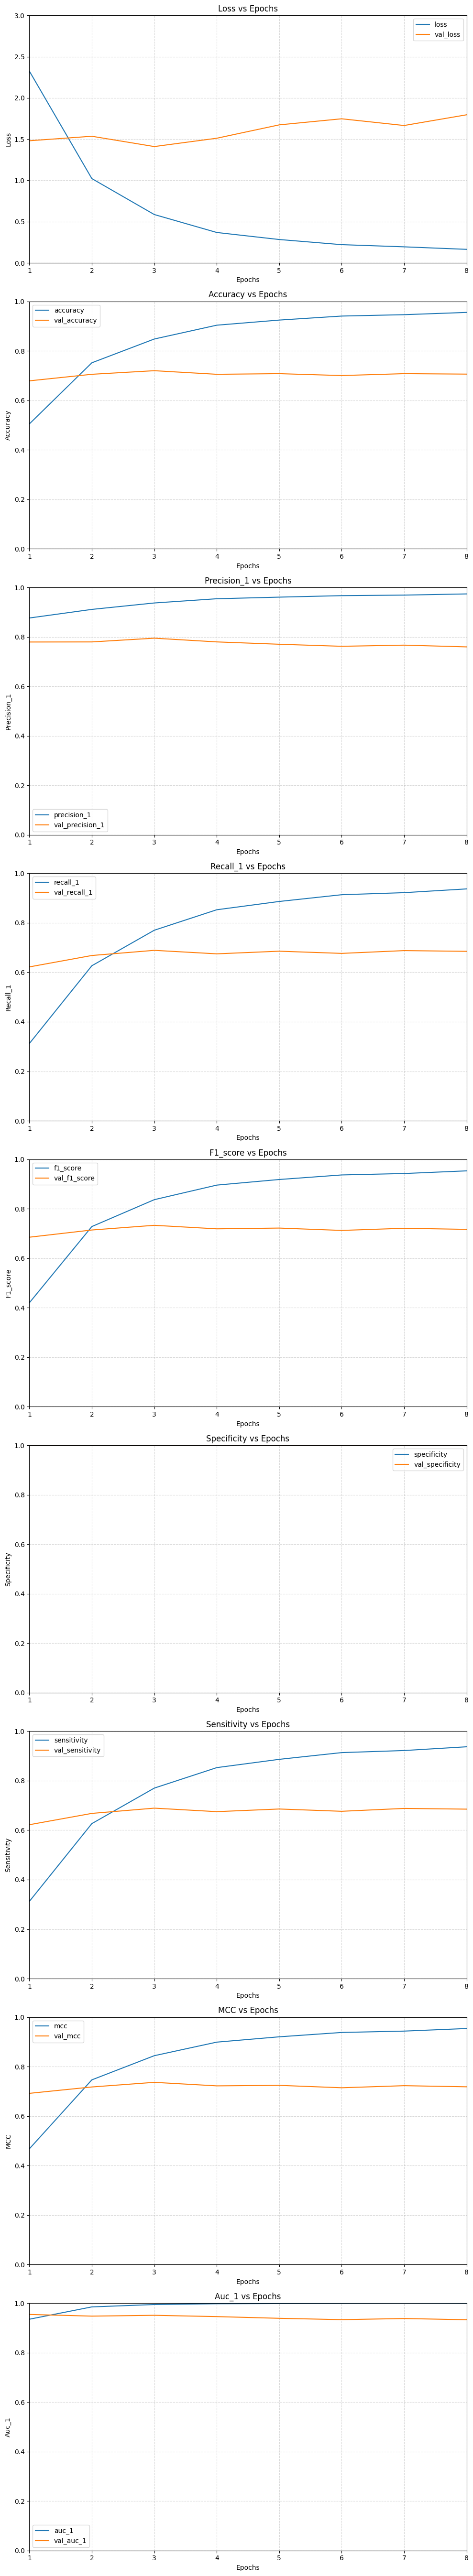

In [21]:
def plot_metrics(history, metric_name_list, figure_size=(10, 6)):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        history: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot
        figure_size: a tuple specifying the size of the figure (width, height)

    Returns:
        None
    """
    # Check if history is a valid Keras History object
    if not isinstance(history, type(tf.keras.callbacks.History())):
        raise ValueError("Invalid Keras History object provided.")

    num_metrics = len(metric_name_list)

    # Create subplots
    figure, axes = plt.subplots(num_metrics, figsize=(figure_size[0], figure_size[1] * num_metrics))

    # Define x-axis range
    rng = range(1, len(history.history[metric_name_list[0]]) + 1)

    for ax, metric_name in zip(axes, metric_name_list):
        # Check if the metric exists in the history
        if metric_name not in history.history:
            raise ValueError(f"Metric '{metric_name}' not found in the training history.")

        metric = history.history[metric_name]
        v_metric = history.history.get(f"val_{metric_name}", None)

        # Plot training metric
        ax.plot(rng, metric, label=metric_name)

        # Plot validation metric if available
        if v_metric is not None:
            ax.plot(rng, v_metric, label=f"val_{metric_name}")

        ax.legend()
        ax.set_xlabel("Epochs")

        # Set y-axis label and title
        ylabel = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_ylabel(ylabel)
        ax.set_title(f"{ylabel} vs Epochs")

        # Set y-axis limits
        max_loss = max(max(metric), max(v_metric)) if v_metric is not None else max(metric)
        min_loss = min(min(metric), min(v_metric)) if v_metric is not None else min(metric)
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()
    plt.show()

metric_names = ["loss", "accuracy", "precision_1", "recall_1", "f1_score",
                "specificity", "sensitivity", "mcc", "auc_1"]
plot_metrics(history, metric_names)

In [22]:
classes = df['labels'].unique()

# Convert predicted probabilities to class labels
predictions = new_model.predict(test_data)
predicted_labels = predictions.argmax(axis=1)

true_labels = test_data.classes
tests = len(true_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
accuracy_percentage = accuracy * 100

errors = np.sum(predicted_labels != true_labels)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

print(report)
print(f'There were {errors} errors in {tests} tests for an accuracy of {accuracy_percentage:6.2f}%')

511/511 [==============================] - 10s 17ms/step
                           precision    recall  f1-score   support

                     ak47     1.0000    0.9625    0.9809        80
            american-flag     0.7500    0.9000    0.8182        10
                 backpack     0.6429    0.9000    0.7500        10
             baseball-bat     0.6667    0.6667    0.6667        15
           baseball-glove     0.4286    0.4615    0.4444        13
          basketball-hoop     1.0000    0.6667    0.8000        15
                      bat     0.6250    0.5556    0.5882         9
                  bathtub     0.3636    0.3636    0.3636        11
                     bear     0.9444    0.7391    0.8293        23
                 beer-mug     1.0000    0.4000    0.5714        10
                billiards     0.5000    0.4444    0.4706         9
               binoculars     0.8710    0.9643    0.9153        28
                 birdbath     0.8750    0.9545    0.9130        22
    